In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compute Loss Function

In [2]:
# calculate du^n / dt^n for arbitrary n and use this to form loss
def compute_derivative(u, t, norm_term, num_u_vectors):
    
    # compute derivative of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all together afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A, v_list, model):
    
    # dictionary to store loss results for plotting
    loss_dict = {} 
    # current loss
    L = 0
    
    # create the trial solution
    model_result = lambda t: model(t)[0]
    u_results = model_result(x)
    
    # determine the number of u vectors
    num_u_vectors = u_results['head 1'].shape[1]
    
    # loss will be the sum of the terms from the "multi-head" model, hence we iterate over each head's outputs
    for i, head_i in enumerate(u_results.keys()):
        # extract the u for the current "head", corresponding to one of the initial conditions
        u = u_results[head_i].unsqueeze(dim=-1)    
    
        # compute A * u
        A_times_u = torch.matmul(A, u)
    
        # compute du/dt (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
        du_dt = compute_derivative(u, x, 0, num_u_vectors)

        # compute the L_T term
        L_t_term = du_dt + A_times_u
        L_t = torch.matmul(L_t_term.mT, L_t_term)

        # compute the L_0 term
        u_0 = model_result(torch.tensor([[0]], dtype=torch.float32))[head_i][0].unsqueeze(dim=-1)
        L_0_term = u_0 - v_list[i]
        L_0 = torch.matmul(L_0_term.T, L_0_term)
    
        # compute the overall loss 
        L += (torch.mean(L_t) + L_0)
    
    # normalize loss and use it to compute the normalization factor
    # norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2 ---> these are now 1 / v[0] **2 (I.C.)
    
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict

# Build Network

In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size, n_heads):
        super(BuildNetwork, self).__init__()
        # store the number of "heads" to use in the model
        self.n_heads = n_heads
        
        # build the layers to use for the forward pass
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        
        # build n_heads output layers, each corresponding to different conditions during training
        self.multi_head_output= nn.ModuleList([nn.Linear(h_size3, output_size)])
        self.multi_head_output.extend([nn.Linear(h_size3, output_size) for i in range(n_heads-1)])
         
    def forward(self, x):
        # dictionary to store the output for each "head" in the model
        u_results = {}
        
        # all "heads" have the same pass through the hidden laers
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        
        # apply the corresponding output layer to each "head"
        for i in range(self.n_heads):
            result_i = self.multi_head_output[i](h)
            u_results[f"head {i + 1}"] = result_i
            
        return u_results, h

# Train Model

In [4]:
# train and evaluate the model
def run_model(iterations, x_range, A, v_list, hid_lay, num_equations, num_heads, true_functs, head_to_track):
        
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(true_functs) == num_equations, 'num_equations must equal the length of true_functs'
    assert len(v_list) == num_heads, 'num_heads must equal the length of v_list'
    
    # build the neural net model
    model = BuildNetwork(1, hid_lay[0], hid_lay[1], hid_lay[2], num_equations, num_heads)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of x values to sample
    min_x, max_x = x_range
    
    # index of the head being tracked for MSE
    head_idx = int(head_to_track.split()[-1]) - 1
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # training loop
    for i in range(iterations):
        
        if i % 1000 == 0:
            print(f"Running Iteration {i + 1}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, v_list, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse for the head that is being monitored ('head_to_track')
        with torch.no_grad():
            current_mse = 0
            for j in range(num_equations):
                network_sol_j = model(x)[0][head_to_track][:, j].unsqueeze(dim=1).numpy()
                true_sol_j = true_functs[j](x, v_list[head_idx])
                current_mse += np.mean((true_sol_j - network_sol_j) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, v_list, axis, head_to_track):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.Tensor(xx))[head_to_track] 
    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        head_idx = int(head_to_track.split()[-1]) - 1
        for i in range(num_curves):
            yys.append(u[:, i].numpy())
            yts.append(true_functs[i](xx, v_list[head_idx]))
                    
    # plot the network solutions
    for i in range(num_curves):
        axis.plot(xx, yys[i], 'x', label=f'Network Solution $u_{i+1}(t)$ ({head_to_track})',
                  linewidth=3.5)
        
    # plot the true solutions
    for i in range(num_curves):
         axis.plot(xx, yts[i], label=f'Actual Solution $u_{i+1}(t)$', linewidth=2.5)

    axis.set_title("u(t) vs t for Actual and Approximation Solutions")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis, head_to_track):
    axis.plot(range(iterations), mses, label=f'MSE ({head_to_track})')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               train_losses, loss_label, mses, head_to_track):
    
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  axis=axs[1], head_to_track=head_to_track)
    
    plot_mse(iterations=iterations, mses=mses, axis=axs[2], 
             head_to_track=head_to_track)
    
    plt.show()

# Choose Network Parameters and Set-up Differential Equations

In [7]:
# set-up network training parameters
x_range = [0, 2]
hid_lay = [128, 128, 128]
num_equations = 2
iterations = 10000

# set-up initial conditions for various differential equation
v_list_two_eq = [torch.tensor([[0.12], [0.35]]), torch.tensor([[0.87], [0.62]]), 
          torch.tensor([[0.34], [0.69]]), torch.tensor([[0.75], [0.25]])]
v_list_one_eq = [torch.tensor([[0.12]]), torch.tensor([[0.87]]), 
          torch.tensor([[0.34]]), torch.tensor([[0.75]])]

# set up A matrix for various differential equations
A_single_eq = torch.tensor([[1.05]])
A_non_coupled_2_eq_easy = torch.tensor([[1.1, 0], [0, 1.1]])
A_non_coupled_2_eq_hard = torch.tensor([[1.1, 0], [0, 3]])
A_coupled_2_eq_easy = torch.tensor([[0, 1.1], [1.1, 0]])
A_coupled_2_eq_hard = torch.tensor([[0, 1.1], [1.5, 0]])


# analytical solutions for various differential equations
true_single_eq = [lambda x, v: (v[0] * np.exp(-1.05 * x)).numpy()]
true_non_coupled_2_eq_easy = [lambda x, v: (v[0] * np.exp(-1.1 * x)).numpy(), 
                              lambda x, v: (v[1] * np.exp(-1.1 * x)).numpy()]
true_non_coupled_2_eq_hard = [lambda x, v: (v[0] * np.exp(-1.1 * x)).numpy(), 
                              lambda x, v: (v[1] * np.exp(-3 * x)).numpy()]
true_coupled_2_eq_easy = [lambda x, v: (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy(),
                         lambda x, v: (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()]
true_coupled_2_eq_hard = [lambda x, v: (0.5 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.428174 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy(),
                          lambda x, v: (0.5 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.583874 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()]


In [8]:
A = A_coupled_2_eq_hard
true_funct = true_coupled_2_eq_hard
v_list = v_list_two_eq
num_heads = 4
head_to_track = 'head 2'

# Run Models

Running Iteration 1
Running Iteration 1001
Running Iteration 2001
Running Iteration 3001
Running Iteration 4001
Running Iteration 5001
Running Iteration 6001
Running Iteration 7001
Running Iteration 8001
Running Iteration 9001
Model Training Complete in 190.453 seconds


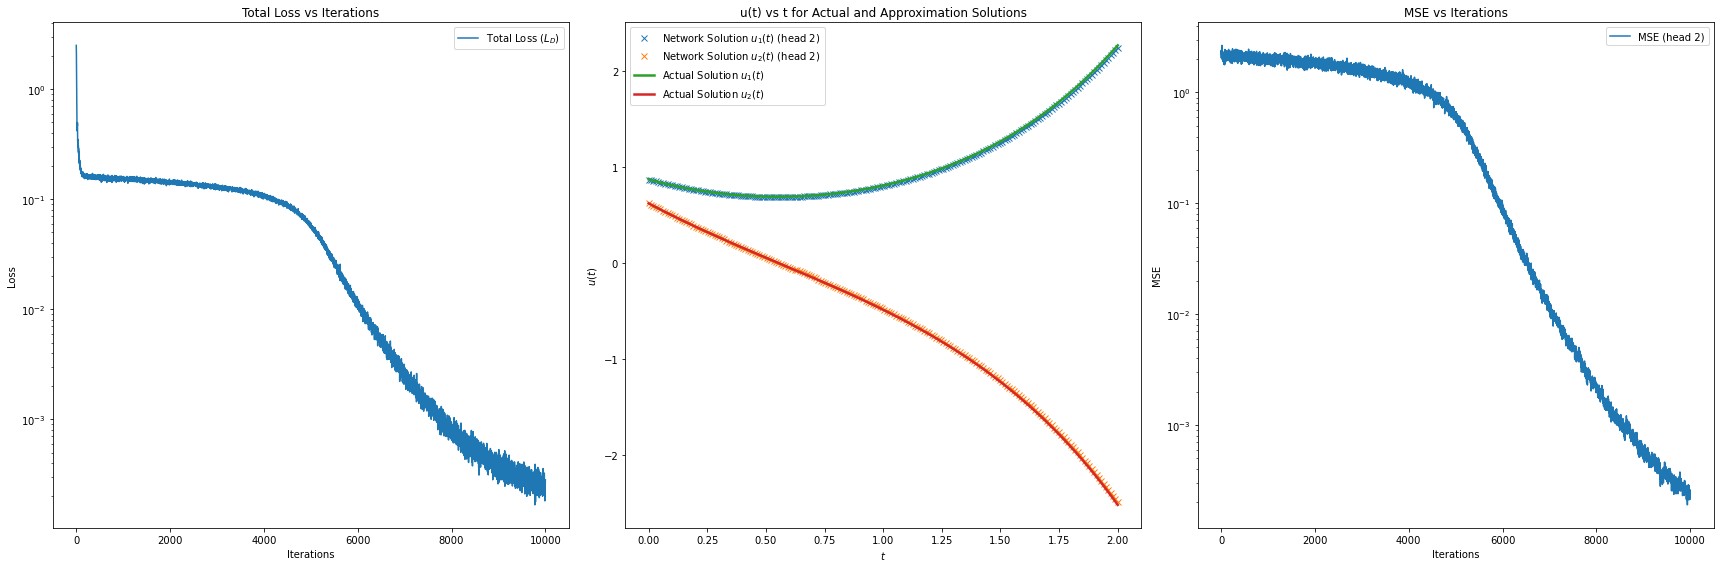

In [9]:
# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range, 
                                                           A=A, v_list=v_list, hid_lay=hid_lay,
                                                           num_equations=num_equations, num_heads=num_heads,
                                                           true_functs=true_funct,
                                                           head_to_track=head_to_track)

# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_funct, iterations=iterations, 
                           trained_model=trained_model, v_list=v_list,
                           train_losses=loss_hist['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist, 
                           head_to_track=head_to_track)

# Perform Transfer Learning

In [ ]:
# generate a set of times to evaluate with
rng = np.random.default_rng()
t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
t_eval = t_eval.reshape(-1, 1)
# pick an initial condition
v = v_list[-1]

# forward pass with t_eval to extract H 
output, H = trained_model(t_eval) 
# reshape "H" to batch_size X num_equations X d // num_equations
H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H = torch.cat((torch.ones(len(t_eval), num_equations, 1), H), 2)

In [ ]:
# compute dH_dt (note: time intensive due to large jacobian calculation)
trained_model_H_only = lambda x: trained_model(x)[1]
dH_dt = torch.autograd.functional.jacobian(trained_model_H_only, t_eval, create_graph=True).sum(axis=2)
dH_dt_new = dH_dt.reshape(-1, num_equations, hid_lay[-1] // num_equations)
dH_dt_new = torch.cat((torch.zeros(len(t_eval), num_equations, 1), dH_dt_new), 2)

In [ ]:
# compute dH_dt * dH_dt.T
dH_dt_times_dH_dt_T = torch.matmul(dH_dt_new.mT, dH_dt_new)

# compute dH_dt * A * H
dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt_new.mT, A), H)

# compute H * A.T * dH_dt
H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A.T), dH_dt_new)

# compute H.T * A.T * A * H
H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)

# compute the "summation portion" of the M matrix 
M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
M_sum_terms = M_sum_terms.sum(axis=0)
M_sum_terms = M_sum_terms / len(t_eval)

# evalute model at t = 0
output_0, H_0 = trained_model(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
# reshape "H" to batch_size X num_equations X d // num_equations
H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_0 = torch.cat((torch.ones(1, num_equations, 1), H_0), 2).squeeze()
H_0 = H_0.unsqueeze(dim=0) if num_equations == 1 else H_0

# compute H_0.T * H_0
H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

# compute the "M" matrix and invert it
M = M_sum_terms + H_0_T_times_H_0
M_inv = torch.linalg.pinv(M)

# compute the output weights by W_out = M ^ -1 * H_0 * u_0
W_out = torch.matmul(torch.matmul(M_inv, H_0.T), v)
print("W_out shape: ", W_out.shape)

# Plot Transfer Learned Solution

In [ ]:
# compute the transfer learned solution
u_transfer = torch.matmul(H, W_out).squeeze()

# plot analytical and transfer learned solution
plt.scatter(t_eval.detach().numpy(), true_funct[0](t_eval.detach().numpy(), v), label= 'True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_funct[1](t_eval.detach().numpy(), v), label= 'True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();

# Change Initial Conditions and Do One-Shot Transfer Learning

In [ ]:
v_transfer = torch.tensor([[1.75], [2.05]])

W_out_transfer = torch.matmul(torch.matmul(M_inv, H_0.T), v_transfer)
u_transfer_initial_change = torch.matmul(H, W_out_transfer).squeeze()

plt.scatter(t_eval.detach().numpy(), true_funct[0](t_eval.detach().numpy(), v_transfer), label='True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer_initial_change[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_funct[1](t_eval.detach().numpy(), v_transfer), label='True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer_initial_change[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();

In [ ]:
# compute the residuals to determine effectiveness of transfer learning when changing initial condition
residuals = ((torch.matmul(dH_dt_new, W_out_transfer) + torch.matmul(A, torch.matmul(H, W_out_transfer))).squeeze()) ** 2
residuals = residuals.reshape(-1, 1).detach().numpy()

print(f"Mean of residuals: {residuals.mean()}")
initial_cond_residuals = ((torch.matmul(H_0, W_out_transfer) - v_transfer) ** 2).mean()
print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plot the residuals
plt.plot(residuals);
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Plot of Residuals");

# Time One-Shot Transfer Learning

In [ ]:
start_one_shot_time = time.time()
rng = np.random.default_rng(12345)
for i in range(10000):
    random_u_0 = torch.Tensor([[rng.random()], [rng.random()]]) # TODO: make this automatically the appropriate size depending on number of equations
    w_out = torch.matmul(torch.matmul(M_inv, H_0.T), random_u_0)
    
end_one_shot_time = time.time() 
total_one_shot = end_one_shot_time - start_one_shot_time
print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

### NEED TO IMPLEMENT CHANGING A IN TRAINING...

# Change Differential Equation ("A")  and Try One-Shot Transfer Learning

In [ ]:
# new differential equation to apply training to
factor_1 = 1.43
transfer_A = torch.tensor([[0, factor_1], [factor_1, 0]])

# compute the new dH_dt * dH_dt.T using SAME dH_dt_new from previous training since it won't change
dH_dt_times_dH_dt_T_new = torch.matmul(dH_dt_new.mT, dH_dt_new)

# compute the new dH_dt * transfer_A * H using dH_dt and H from previous training since it won't change
dH_dt_times_A_times_H_new = torch.matmul(torch.matmul(dH_dt_new.mT, transfer_A), H)

# compute the new H * transfer_A.T * dH_dt using dH_dt and H from previous training since it won't change
H_times_A_T_times_dH_dt_new = torch.matmul(torch.matmul(H.mT, transfer_A.T), dH_dt_new)

# compute the new H.T * transfer_A.T * transfer_A * H
H_T_times_A_T_times_A_times_H_new = torch.matmul(torch.matmul(torch.matmul(H.mT, transfer_A.T), transfer_A), H)

# compute the new "summation portion" of the M matrix 
M_sum_terms_new = dH_dt_times_dH_dt_T_new + dH_dt_times_A_times_H_new + H_times_A_T_times_dH_dt_new + H_T_times_A_T_times_A_times_H_new
M_sum_terms_new = M_sum_terms_new.sum(axis=0)
M_sum_terms_new = M_sum_terms_new / len(t_eval)

# compute the new "M" matrix and invert it
M_new = M_sum_terms_new + H_0_T_times_H_0
M_inv_new = torch.linalg.pinv(M_new)

# compute the output weights by W_out = M ^ -1 * H_0 * u_0
W_out_new_A = torch.matmul(torch.matmul(M_inv_new, H_0.T), v)
print("W_out shape: ", W_out_new_A.shape)

In [ ]:
# true_f1_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
# true_f2_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
true_f1_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.428174 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
true_f2_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.583874 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()

u_transfer_equation_change = torch.matmul(H, W_out_new_A).squeeze()

plt.scatter(t_eval.detach().numpy(), true_f1_coupled_2_eq_transfer_new_A(t_eval.detach().numpy()), label='True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer_equation_change[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_f2_coupled_2_eq_transfer_new_A(t_eval.detach().numpy()), label='True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer_equation_change[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();